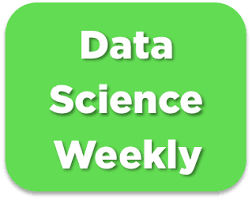

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [5]:
data = pd.read_csv('/Users/fezzibasma/Desktop/Data/Data_Full-Stack/Machine learning Supervisé/Projet Conversion rate template/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [6]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

## EDA 

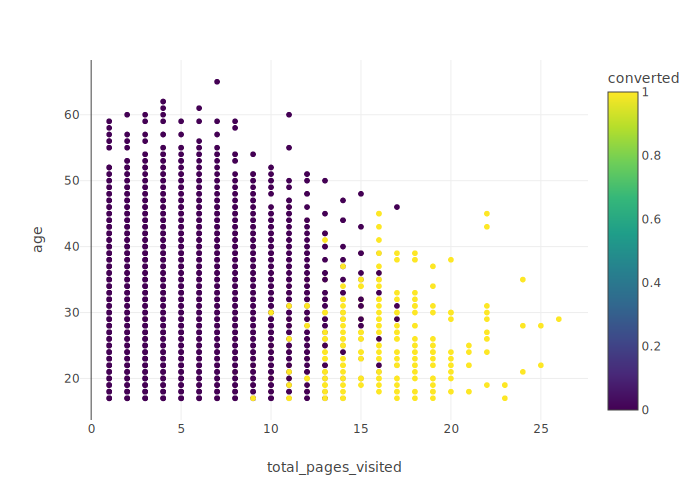

In [8]:
fig = px.scatter(data_sample, x='total_pages_visited', y='age',color='converted')
fig.show()

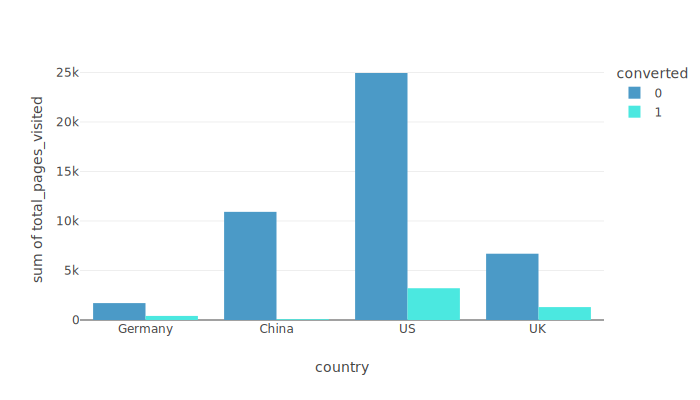

In [9]:
fig = px.histogram(data_sample, x="country", y="total_pages_visited",
             color='converted', barmode='group',
             height=400)
fig.show()

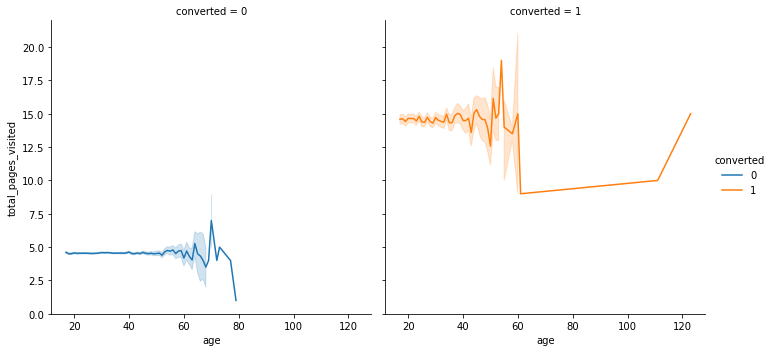

In [10]:
import seaborn as sns
sns.relplot(
    data=data, kind="line",
    x="age", y="total_pages_visited", col="converted",
    hue="converted",
)

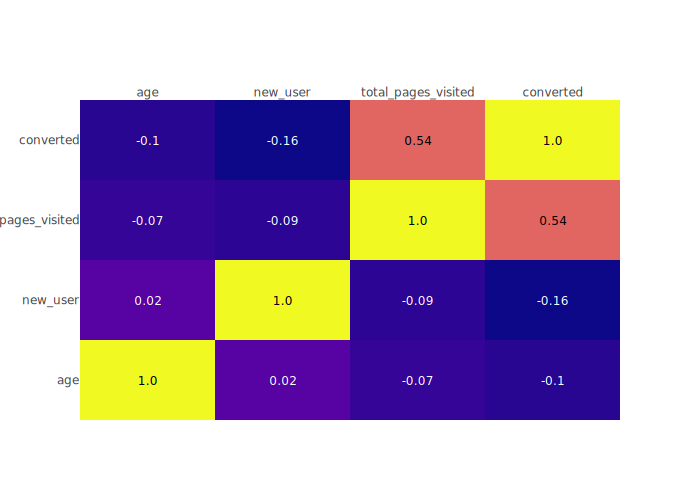

In [11]:
# Correlation matrix
corr_matrix = pd.DataFrame(data_sample).corr().round(2)
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

#### Nous pouvons déduire qu'il y a très peu voire pas du tout de correlation entre les features. D'autant qu'il y a une présence d'outliers au niveau des âges et de l'information non pertinentes concernant la chine et la germany. Nous allons se focaliser sur le preprocessing afin de remédier à ces premieres constatations de notre dataset

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [12]:
print('Dropping outliers in Age...')
data=data[data.age<60]
print('Keeping only UK or US')
data=data[(data['country']=='UK') | (data['country']=='US')]

Dropping outliers in Age...
Keeping only UK or US


In [13]:
#Suppression des valeurs en double
data.dropna(inplace=True)

In [14]:
# attention, le new_user est déjà encodé ( c'est une variable catégorielle,pas de besoin de l'encoder)
numeric_features = ['age','total_pages_visited','new_user']
categorical_features = ['country','source']
target_variable='converted'

y = data.loc[:, target_variable]
X = data.drop(target_variable,axis=1)

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [15]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [16]:
numerical_pipeline=make_pipeline(StandardScaler())        #définir les chaines de transformations que chacune des categories va subir comme transformations
categorical_pipeline=make_pipeline(OneHotEncoder(drop="first"))

In [17]:

preprocessor = make_column_transformer((numerical_pipeline,numeric_features),(categorical_pipeline,categorical_features))  #on injecte ces pipelines dans make column transformer pour nous retourner un preprocessor . Ce dernier sera utilisé dans le pipeline final


## Training pipeline on multiple models and compare performance

In [18]:
#Let's define the model that will been trained on that data : 

from sklearn.ensemble import RandomForestClassifier

#Linear Models

model_SGDC=make_pipeline(preprocessor,SGDClassifier())

model_LR=make_pipeline(preprocessor,LogisticRegression())

#Ensembliste Models

model_DTC=make_pipeline(preprocessor,DecisionTreeClassifier())

model_RFC=make_pipeline(preprocessor,RandomForestClassifier())


In [19]:
#let score df our dataframe to stock result of each model trained
scores_df = pd.DataFrame(columns = ['model', 'f1 score', 'set'])

In [20]:
#Perfom Grid search on SGDClassifier ()
# Grid of values to be tested
params = {
        #méthodes linéaires
        'sgdclassifier__penalty' : ['l1','l2'],
}

gridsearch=GridSearchCV(model_SGDC,param_grid=params,cv=3,scoring='f1')
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, y_train))
print("f1 score on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'SGDClassifier', 'f1 score': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'SGDClassifier', 'f1 score': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df


...Done.
Best hyperparameters :  {'sgdclassifier__penalty': 'l1'}
Best validation f1 score :  0.7657864639214287

f1 score on training set :  0.770064148253742
f1 score on test set :  0.7639710716633794


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/2604761276.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/2604761276.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.770064,train
1,SGDClassifier,0.763971,test


In [21]:
#Perfom Grid search on LogisticRegression ()
# Grid of values to be tested

params = {
        #méthodes linéaires
        'logisticregression__penalty': ['l1','l2','elasticnet','none'],
        'logisticregression__C' : [0.01,0.1,0.5,1],
}

gridsearch=GridSearchCV(model_LR,param_grid=params,cv=3,scoring='f1')
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, y_train))
print("f1 score on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'LogisticRegression', 'f1 score': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'LogisticRegression', 'f1 score': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/opt/anaconda3/lib/pyt

...Done.
Best hyperparameters :  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'none'}
Best validation f1 score :  0.7639886521977038

f1 score on training set :  0.7647920328060926
f1 score on test set :  0.7552542372881357


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/587550316.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/587550316.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.770064,train
1,SGDClassifier,0.763971,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test


In [22]:
#Perfom Grid search on DecisionTreeClassifier ()
# Grid of values to be tested

params = {
        #méthodes ensemblistes
        'decisiontreeclassifier__min_samples_split': [2,5,10,15,20],
        'decisiontreeclassifier__class_weight': ['None','balanced'],
        'decisiontreeclassifier__criterion' : ['gini','entropy'],
}

gridsearch=GridSearchCV(model_DTC,param_grid=params,cv=3,scoring='f1')
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, y_train))
print("f1 score on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'DecisionTree', 'f1 score': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'DecisionTree', 'f1 score': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.9/site-pack

...Done.
Best hyperparameters :  {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__min_samples_split': 10}
Best validation f1 score :  0.5204205373932576

f1 score on training set :  0.5677956124170951
f1 score on test set :  0.5174625801853172


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/2207766863.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/2207766863.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.770064,train
1,SGDClassifier,0.763971,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.567796,train
5,DecisionTree,0.517463,test


In [24]:
#Perfom Grid search on RandomForest ()
# Grid of values to be tested

params = {
        'randomforestclassifier__n_estimators': [10,50,100,150,1000,1500],
        'randomforestclassifier__criterion' : ['gini','entropy'],
}

gridsearch=GridSearchCV(model_RFC,param_grid=params,cv=3,scoring='f1')
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score: ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, y_train))
print("f1 score on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'random_forest', 'f1 score': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'random_forest', 'f1 score': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

...Done.
Best hyperparameters :  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 1000}
Best validation f1 score:  0.736060089466443

f1 score on training set :  0.7943427863235402
f1 score on test set :  0.7456492637215529


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/226383579.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_66674/226383579.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.770064,train
1,SGDClassifier,0.763971,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.567796,train
5,DecisionTree,0.517463,test
6,random_forest,0.794343,train
7,random_forest,0.745649,test


In [ ]:
scores_df.drop(labels=None, axis=0, index=[6,7,8,9,10], columns=None, level=None, inplace=True, errors='raise')

In [ ]:
scores_df

,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
11,random_forest,0.794403,train
12,random_forest,0.749665,test


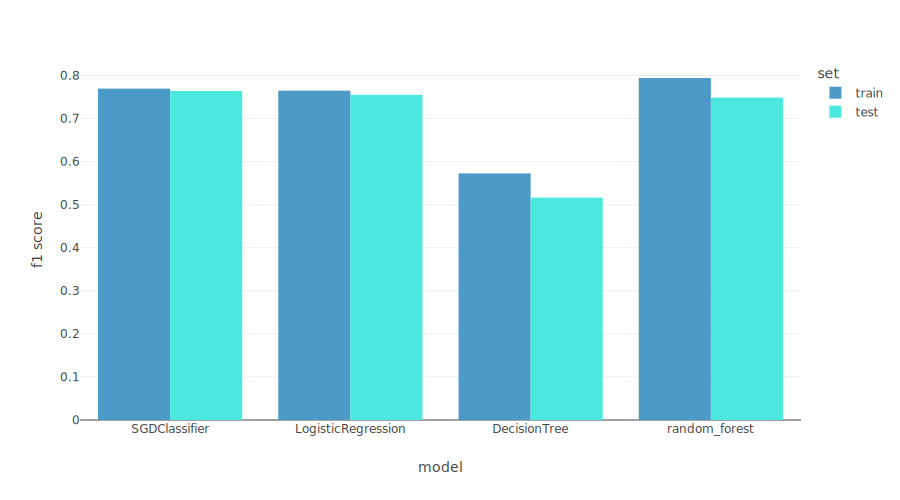

In [ ]:
px.bar(scores_df, x = "model", y = 'f1 score', color = 'set', barmode = 'group', width = 900)

## Ensembling & Stacking models


## Partie Bagging sur SGDClassifier et LogisticRegression

In [ ]:
from sklearn.ensemble import BaggingClassifier

print('Training Bagging of SGDClassifier...')

SGDC = SGDClassifier(penalty='l2') # Same hyperparameters as best RF model
bagging_SGDC=make_pipeline(preprocessor,BaggingClassifier(base_estimator=SGDC, n_estimators = 20))
#bagging_SGDC = BaggingClassifier(base_estimator=SGDC, n_estimators = 20)
bagging_SGDC.fit(X_train, y_train)
print("...Done.")

y_test_pred = bagging_SGDC.predict(X_test)
y_train_pred = bagging_SGDC.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'bagging_SGDC', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'bagging_SGDC', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

Training Bagging of SGDClassifier...
...Done.
f1 score on training set :  0.7680855676808557
f1 score on test set :  0.7610146862483311


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/4232720944.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/4232720944.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


In [ ]:
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier

print('Training Bagging of LogisticRegression...')

LR = LogisticRegression(C=0.01) # Same hyperparameters as best RF model
bagging_LR=make_pipeline(preprocessor,BaggingClassifier(base_estimator=LR, n_estimators = 20))
bagging_LR.fit(X_train, y_train)
print("...Done.")

y_test_pred = bagging_LR.predict(X_test)
y_train_pred = bagging_LR.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'bagging_LR', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'bagging_LR', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

Training Bagging of LogisticRegression...
...Done.
f1 score on training set :  0.7615521327014219
f1 score on test set :  0.7501720578114247


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/960370664.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/960370664.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


## Partie Adaboost sur LogisticRegression

In [ ]:
logistic_regression = LogisticRegression()
adaboost_logreg = make_pipeline(preprocessor,AdaBoostClassifier(base_estimator=logistic_regression))
adaboost_logreg.fit(X_train, y_train)

y_test_pred = adaboost_logreg.predict(X_test)
y_train_pred = adaboost_logreg.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
f1 score on training set :  0.7640515222482436
f1 score on test set :  0.7547425474254743


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/1110238583.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/1110238583.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


In [ ]:
adaboost_DT = make_pipeline(preprocessor,AdaBoostClassifier())
adaboost_DT.fit(X_train, y_train)

y_test_pred = adaboost_DT.predict(X_test)
y_train_pred = adaboost_DT.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'adaboost_DT', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_DT', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

f1 score on training set :  0.7560345463940356
f1 score on test set :  0.7505154639175258


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/1917925384.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/1917925384.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


## Partie GradientDescent

In [ ]:
GBC = make_pipeline(preprocessor,GradientBoostingClassifier())
GBC.fit(X_train, y_train)

y_test_pred = GBC.predict(X_test)
y_train_pred = GBC.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'GBC', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'GBC', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

## Partie XGBoost 

In [ ]:
# from xgboost import XGBClassifier


# model_XGBoost=make_pipeline(preprocessor,XGBClassifier())

# params = {
#     'max_depth': [4, 6, 8, 10],
#     'min_child_weight': [1, 2, 4, 6, 8],
#     'n_estimators': [2, 4, 6, 8, 10, 12],
# }

# gridsearch=GridSearchCV(model_XGBoost,param_grid=params,cv=3,scoring='f1')
# gridsearch.fit(X_train, y_train)
# print("...Done.")
# print("Best hyperparameters : ", gridsearch.best_params_)
# print("Best validation f1 score : ", gridsearch.best_score_)
# print()
# print("f1 score on training set : ", gridsearch.score(X_train, y_train))
# print("f1 score on test set : ", gridsearch.score(X_test, y_test))
# scores_df = scores_df.append({'model': 'xgboost', 'f1 score': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
# scores_df = scores_df.append({'model': 'xgboost', 'f1 score': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
# scores_df

In [ ]:
from xgboost import XGBClassifier


XGBC = make_pipeline(preprocessor,XGBClassifier())
XGBC.fit(X_train, y_train)

y_test_pred = XGBC.predict(X_test)
y_train_pred = XGBC.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'XGBC', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'XGBC', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

f1 score on training set :  0.7729292634953012
f1 score on test set :  0.7545393409549429


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/2152272556.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/2152272556.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


In [ ]:
from xgboost import XGBClassifier


XGBC_hyperparameter = make_pipeline(preprocessor,XGBClassifier(min_child_weight=4,n_estimators=10))
XGBC_hyperparameter.fit(X_train, y_train)

y_test_pred = XGBC_hyperparameter.predict(X_test)
y_train_pred = XGBC_hyperparameter.predict(X_train)

print("f1 score on training set : ", f1_score(y_train, y_train_pred))
print("f1 score on test set : ", f1_score(y_test, y_test_pred))

scores_df = scores_df.append({'model': 'XGBC_hyperparameter', 'f1 score': f1_score(y_test, y_test_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'XGBC_hyperparameter', 'f1 score': f1_score(y_train, y_train_pred), 'set': 'test'}, ignore_index = True)
scores_df

f1 score on training set :  0.7681781789067618
f1 score on test set :  0.7575962187711005


/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/26060817.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/69/2xnjng8d15j5264htcrb3x640000gn/T/ipykernel_6285/26060817.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


In [ ]:
# scores_df = scores_df.sort_values(by = ['set', 'f1 score'], ascending = False)

scores_df= scores_df.sort_index(ascending = True)
scores_df

,model,f1 score,set
0,SGDClassifier,0.769537,train
1,SGDClassifier,0.764115,test
2,LogisticRegression,0.764792,train
3,LogisticRegression,0.755254,test
4,DecisionTree,0.572673,train
5,DecisionTree,0.516408,test
6,random_forest,0.794403,train
7,random_forest,0.749665,test
8,bagging_SGDC,0.761015,train
9,bagging_SGDC,0.768086,test


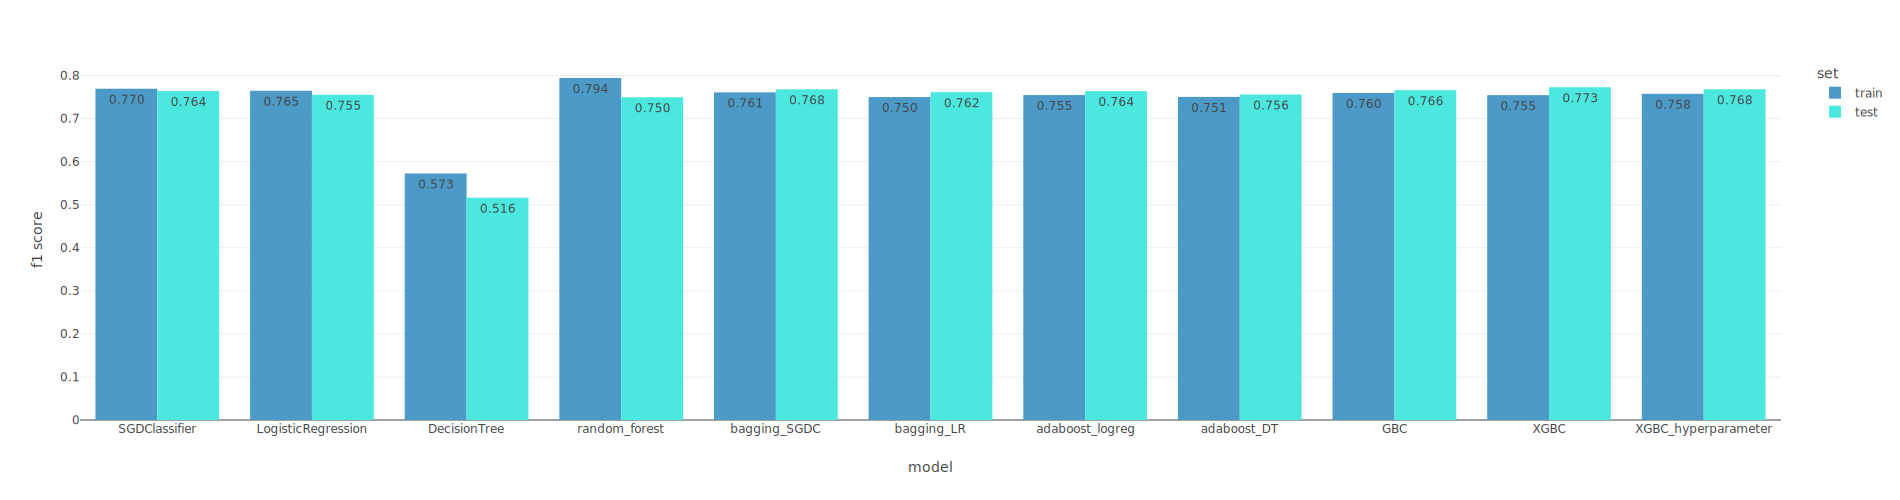

In [ ]:
px.bar(scores_df, x = 'model', y = 'f1 score', color = 'set', barmode = 'group', width = 1900, text_auto='.3f')